In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Starting FruitVision MoCo dual-head pipeline
Device: cuda
Dataset root: /kaggle/input/fvision/Fruits Original-ML-GRP-07
Total images: 10153
Per-fruit counts: {'apple': 2038, 'banana': 2041, 'grape': 2010, 'mango': 2008, 'orange': 2056}
Per-state counts: {'fresh': 3799, 'rotten': 3178, 'formalin': 3176}
Train size: 8126 | Test size: 2027
Built pretrain loader with 63 batches
Built linear-train loader with 32 batches
Built test loader with 8 batches
Starting MoCo pretraining for 2 epochs on cuda
[MoCo] Epoch 1/2 avg_loss=7.9193 saved=/kaggle/working/moco_epoch_1.pth
[MoCo] Epoch 2/2 avg_loss=8.5280 saved=/kaggle/working/moco_epoch_2.pth
Finished MoCo pretraining
Loaded frozen encoder from /kaggle/working/moco_epoch_2.pth
Starting linear head training for 15 epochs
[Linear] Epoch 1/15 train_loss=5707.1127 test_acc_fruit=82.04% test_acc_state=42.72%
[Linear] Epoch 2/15 train_loss=1581.5404 test_acc_fruit=86.38% test_acc_state=58.51%
[Linear] Epoch 3/15 train_loss=1231.9928 test_acc_fruit=8

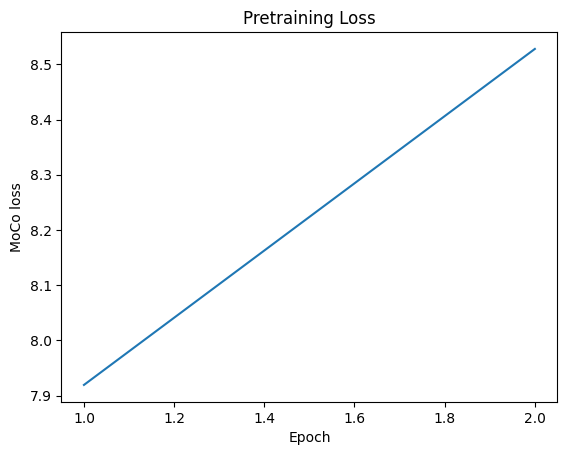

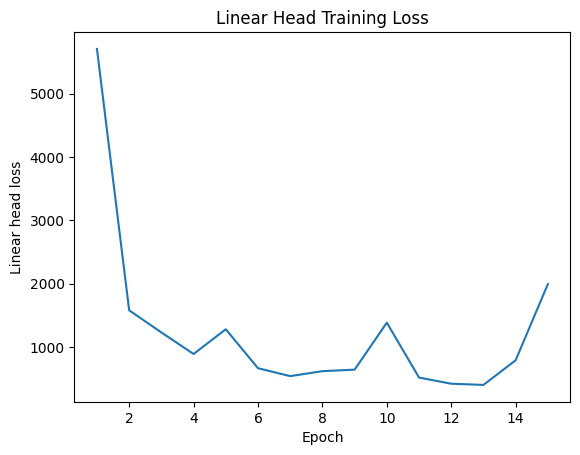

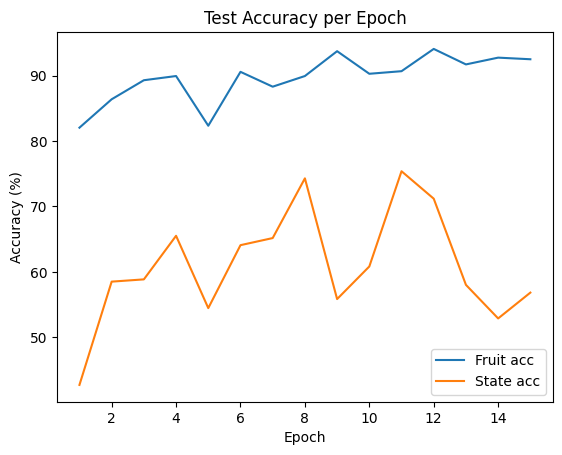

Final metrics (percentages where applicable):
{'fruit_acc': 92.5, 'state_acc': 56.83, 'fruit_bacc': 92.56, 'state_bacc': 54.14}
Rendering confusion matrices


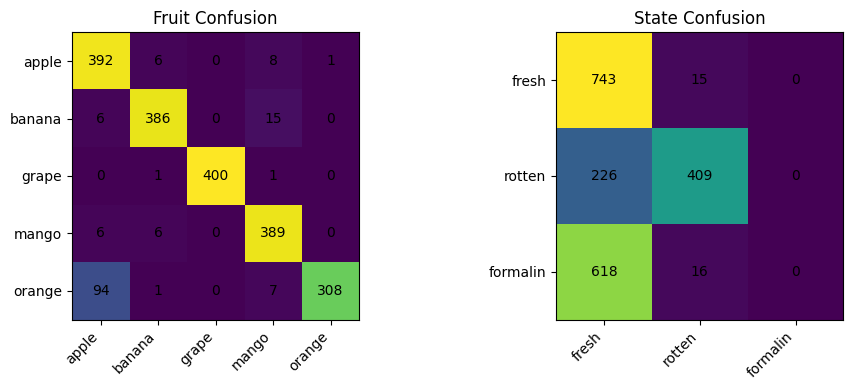

Pipeline complete


In [5]:
from __future__ import annotations
import os, random, math
from pathlib import Path
from typing import List, Tuple, Optional, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
import torchvision.models as models
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, balanced_accuracy_score

SEED = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_PRETRAIN = 128
BATCH_LINEAR = 256
EPOCHS_PRETRAIN = 10
EPOCHS_LINEAR = 15
LR_PRETRAIN = 0.3
LR_LINEAR = 30.0
WEIGHT_DECAY = 1e-4
CROP_SIZE = 224
NUM_WORKERS = 4
QUEUE_K = 8192
MOMENTUM_M = 0.999
TEMP_T = 0.2
PROJ_DIM = 128
MLP_HIDDEN = 2048
BACKBONE = 'resnet18'
TEST_RATIO = 0.2
OUTPUT_DIR = '/kaggle/working'

FRUITS = ["apple", "banana", "grape", "mango", "orange"]
STATES = ["fresh", "rotten", "formalin"]
STATE_NORMALIZE = {"formalin-mixed": "formalin", "formalin_mixed": "formalin", "formalin": "formalin", "fresh": "fresh", "rotten": "rotten"}
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def log(msg: str):
    print(msg, flush=True)


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def autodetect_data_root() -> Optional[str]:
    base = Path('/kaggle/input')
    if not base.exists():
        return None
    cands = []
    for p in base.rglob('*'):
        if p.is_dir():
            names = {d.name.lower() for d in p.iterdir() if d.is_dir()}
            if len(set(FRUITS) & names) >= 3:
                cands.append(p)
    if not cands:
        return None
    best = min(cands, key=lambda x: len(str(x)))
    return str(best)


class FruitStateDataset(Dataset):
    def __init__(self, root: str, transform=None):
        self.root = Path(root)
        self.transform = transform
        self.samples: List[Tuple[str, int, int]] = []
        for fruit_dir in sorted([d for d in self.root.iterdir() if d.is_dir()]):
            f = fruit_dir.name.lower()
            if f not in FRUITS:
                continue
            for state_dir in sorted([d for d in fruit_dir.iterdir() if d.is_dir()]):
                s_raw = state_dir.name.lower()
                s = STATE_NORMALIZE.get(s_raw, s_raw)
                if s not in STATES:
                    continue
                for img in state_dir.rglob('*'):
                    if img.suffix.lower() in IMG_EXTS:
                        self.samples.append((str(img), FRUITS.index(f), STATES.index(s)))
        if not self.samples:
            raise RuntimeError(f"No images found under {root}")
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        p, f, s = self.samples[idx]
        x = Image.open(p).convert('RGB')
        if self.transform:
            x = self.transform(x)
        return x, (f, s)


def stratified_split_indices(samples: List[Tuple[str, int, int]], test_ratio: float, seed: int = 42) -> Tuple[List[int], List[int]]:
    rng = random.Random(seed)
    groups: Dict[Tuple[int,int], List[int]] = {}
    for i, (_, f, s) in enumerate(samples):
        groups.setdefault((f,s), []).append(i)
    train_idx, test_idx = [], []
    for k, idxs in groups.items():
        rng.shuffle(idxs)
        n_test = max(1, int(len(idxs) * test_ratio)) if len(idxs) > 1 else 1
        test_idx.extend(idxs[:n_test])
        train_idx.extend(idxs[n_test:])
    rng.shuffle(train_idx)
    rng.shuffle(test_idx)
    return train_idx, test_idx


class TwoCropsTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return q, k


def moco_v2_augmentation(crop_size: int = CROP_SIZE):
    cj = T.ColorJitter(0.4, 0.4, 0.4, 0.1)
    base = T.Compose([
        T.RandomResizedCrop(crop_size, scale=(0.2, 1.0)),
        T.RandomHorizontalFlip(),
        T.RandomApply([cj], p=0.8),
        T.RandomGrayscale(p=0.2),
        T.GaussianBlur(kernel_size=int(0.1 * crop_size) // 2 * 2 + 1),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    return TwoCropsTransform(base)


def eval_transform(crop_size: int = CROP_SIZE):
    return T.Compose([
        T.Resize(int(crop_size * 256 / 224)),
        T.CenterCrop(crop_size),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])


class ProjectionMLP(nn.Module):
    def __init__(self, dim: int, hidden: int = MLP_HIDDEN, out: int = PROJ_DIM):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(dim, hidden), nn.ReLU(inplace=True), nn.Linear(hidden, out))
    def forward(self, x):
        return self.net(x)


def make_backbone(name: str):
    name = name.lower()
    if name == 'resnet18':
        m = models.resnet18(weights=None)
    elif name == 'resnet34':
        m = models.resnet34(weights=None)
    else:
        m = models.resnet50(weights=None)
    return m


class MoCo(nn.Module):
    def __init__(self, base_encoder_fn, dim=PROJ_DIM, K=QUEUE_K, m=MOMENTUM_M, T=TEMP_T, mlp_hidden=MLP_HIDDEN):
        super().__init__()
        self.encoder_q = base_encoder_fn()
        self.encoder_k = base_encoder_fn()
        feat_dim = self.encoder_q.fc.in_features
        self.encoder_q.fc = nn.Identity()
        self.encoder_k.fc = nn.Identity()
        self.proj_q = ProjectionMLP(feat_dim, hidden=mlp_hidden, out=dim)
        self.proj_k = ProjectionMLP(feat_dim, hidden=mlp_hidden, out=dim)
        for pq, pk in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            pk.data.copy_(pq.data)
            pk.requires_grad = False
        for pq, pk in zip(self.proj_q.parameters(), self.proj_k.parameters()):
            pk.data.copy_(pq.data)
            pk.requires_grad = False
        self.m = m
        self.T = T
        self.K = K
        self.register_buffer('queue', F.normalize(torch.randn(dim, K), dim=0))
        self.register_buffer('queue_ptr', torch.zeros(1, dtype=torch.long))
    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for pq, pk in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            pk.data = pk.data * self.m + pq.data * (1. - self.m)
        for pq, pk in zip(self.proj_q.parameters(), self.proj_k.parameters()):
            pk.data = pk.data * self.m + pq.data * (1. - self.m)
    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        bs = keys.shape[0]
        ptr = int(self.queue_ptr)
        end = ptr + bs
        if end <= self.K:
            self.queue[:, ptr:end] = keys.T
        else:
            first = self.K - ptr
            self.queue[:, ptr:] = keys[:first].T
            self.queue[:, :bs-first] = keys[first:].T
        self.queue_ptr[0] = (ptr + bs) % self.K
    def forward(self, im_q, im_k):
        q = F.normalize(self.proj_q(self.encoder_q(im_q)), dim=1)
        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = F.normalize(self.proj_k(self.encoder_k(im_k)), dim=1)
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])
        logits = torch.cat([l_pos, l_neg], dim=1) / self.T
        labels = torch.zeros(logits.size(0), dtype=torch.long, device=logits.device)
        self._dequeue_and_enqueue(k)
        return logits, labels


class _PretrainWrap(Dataset):
    def __init__(self, base: FruitStateDataset, transform):
        self.base = base
        self.transform = transform
    def __len__(self):
        return len(self.base)
    def __getitem__(self, i):
        x, _ = self.base[i]
        q, k = self.transform(x)
        return (q, k), 0


def build_pretrain_loader(ds: FruitStateDataset, idxs: List[int]) -> DataLoader:
    subset = Subset(ds, idxs)
    twocrop = moco_v2_augmentation(CROP_SIZE)
    wrap = _PretrainWrap(subset, twocrop)
    loader = DataLoader(wrap, batch_size=BATCH_PRETRAIN, shuffle=True, num_workers=NUM_WORKERS, drop_last=True, pin_memory=True)
    log(f"Built pretrain loader with {len(loader)} batches")
    return loader


def build_linear_loader(ds: FruitStateDataset, idxs: List[int]) -> DataLoader:
    subset = Subset(FruitStateDataset(ds.root, transform=eval_transform(CROP_SIZE)), idxs)
    def collate(batch):
        xs, yf, ys = [], [], []
        for x, (f, s) in batch:
            xs.append(x); yf.append(f); ys.append(s)
        return torch.stack(xs,0), (torch.tensor(yf), torch.tensor(ys))
    loader = DataLoader(subset, batch_size=BATCH_LINEAR, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate)
    log(f"Built linear-train loader with {len(loader)} batches")
    return loader


def build_test_loader(ds: FruitStateDataset, idxs: List[int]) -> DataLoader:
    subset = Subset(FruitStateDataset(ds.root, transform=eval_transform(CROP_SIZE)), idxs)
    def collate(batch):
        xs, yf, ys = [], [], []
        for x, (f, s) in batch:
            xs.append(x); yf.append(f); ys.append(s)
        return torch.stack(xs,0), (torch.tensor(yf), torch.tensor(ys))
    loader = DataLoader(subset, batch_size=BATCH_LINEAR, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate)
    log(f"Built test loader with {len(loader)} batches")
    return loader


def pretrain_moco(train_loader: DataLoader, base_encoder_fn, epochs: int = EPOCHS_PRETRAIN):
    device = torch.device(DEVICE)
    model = MoCo(base_encoder_fn).to(device)
    opt = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=LR_PRETRAIN, momentum=0.9, weight_decay=WEIGHT_DECAY)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    losses = []
    log(f"Starting MoCo pretraining for {epochs} epochs on {DEVICE}")
    for ep in range(1, epochs+1):
        model.train()
        run = 0.0
        n = 0
        for (im_q, im_k), _ in train_loader:
            im_q = im_q.to(device, non_blocking=True)
            im_k = im_k.to(device, non_blocking=True)
            logits, labels = model(im_q, im_k)
            loss = F.cross_entropy(logits, labels)
            opt.zero_grad(); loss.backward(); opt.step()
            run += float(loss.item()); n += 1
        sch.step()
        avg = run / max(1,n)
        losses.append(avg)
        ck = os.path.join(OUTPUT_DIR, f'moco_epoch_{ep}.pth')
        torch.save({'epoch': ep, 'state_dict': model.state_dict()}, ck)
        log(f"[MoCo] Epoch {ep}/{epochs} avg_loss={avg:.4f} saved={ck}")
    log("Finished MoCo pretraining")
    return model, losses


class DualHead(nn.Module):
    def __init__(self, in_dim: int):
        super().__init__()
        self.fruit = nn.Linear(in_dim, len(FRUITS))
        self.state = nn.Linear(in_dim, len(STATES))
    def forward(self, x):
        return self.fruit(x), self.state(x)


def load_frozen_encoder_from_moco(ckpt_path: str, backbone_name: str):
    enc = make_backbone(backbone_name)
    feat_dim = enc.fc.in_features
    enc.fc = nn.Identity()
    ck = torch.load(ckpt_path, map_location='cpu')
    enc_state = {k.replace('encoder_q.', ''): v for k, v in ck['state_dict'].items() if k.startswith('encoder_q.')}
    enc.load_state_dict(enc_state, strict=False)
    for p in enc.parameters():
        p.requires_grad = False
    log(f"Loaded frozen encoder from {ckpt_path}")
    return enc, feat_dim


def train_dual_linear_head(enc: nn.Module, feat_dim: int, train_loader: DataLoader, test_loader: DataLoader, epochs: int = EPOCHS_LINEAR):
    device = torch.device(DEVICE)
    enc = enc.to(device).eval()
    head = DualHead(feat_dim).to(device)
    opt = torch.optim.SGD(head.parameters(), lr=LR_LINEAR, momentum=0.9)
    ce = nn.CrossEntropyLoss()
    train_losses = []
    test_acc_fruits = []
    test_acc_states = []
    log(f"Starting linear head training for {epochs} epochs")
    for ep in range(1, epochs+1):
        head.train()
        run = 0.0; cnt = 0
        for x, (yf, ys) in train_loader:
            x = x.to(device); yf = yf.to(device); ys = ys.to(device)
            with torch.no_grad():
                feats = enc(x)
            lf, ls = head(feats)
            loss = ce(lf, yf) + ce(ls, ys)
            opt.zero_grad(); loss.backward(); opt.step()
            run += float(loss.item()); cnt += 1
        avg = run / max(1,cnt)
        train_losses.append(avg)
        head.eval()
        ytf, yts, ypf, yps = [], [], [], []
        with torch.no_grad():
            for x, (yf, ys) in test_loader:
                x = x.to(device)
                feats = enc(x)
                lf, ls = head(feats)
                ytf.extend(yf.numpy().tolist())
                yts.extend(ys.numpy().tolist())
                ypf.extend(lf.argmax(1).cpu().numpy().tolist())
                yps.extend(ls.argmax(1).cpu().numpy().tolist())
        acc_f = accuracy_score(ytf, ypf)
        acc_s = accuracy_score(yts, yps)
        test_acc_fruits.append(acc_f)
        test_acc_states.append(acc_s)
        log(f"[Linear] Epoch {ep}/{epochs} train_loss={avg:.4f} test_acc_fruit={acc_f*100:.2f}% test_acc_state={acc_s*100:.2f}%")
    log("Finished linear head training")
    return head, train_losses, test_acc_fruits, test_acc_states


def final_evaluation(enc: nn.Module, head: DualHead, test_loader: DataLoader):
    device = torch.device(DEVICE)
    enc = enc.to(device).eval(); head = head.to(device).eval()
    ytf, yts, ypf, yps = [], [], [], []
    with torch.no_grad():
        for x, (yf, ys) in test_loader:
            x = x.to(device)
            feats = enc(x)
            lf, ls = head(feats)
            ytf.extend(yf.numpy().tolist())
            yts.extend(ys.numpy().tolist())
            ypf.extend(lf.argmax(1).cpu().numpy().tolist())
            yps.extend(ls.argmax(1).cpu().numpy().tolist())
    prf_f = precision_recall_fscore_support(ytf, ypf, average='macro', zero_division=0)
    prf_s = precision_recall_fscore_support(yts, yps, average='macro', zero_division=0)
    bacc_f = balanced_accuracy_score(ytf, ypf)
    bacc_s = balanced_accuracy_score(yts, yps)
    cm_f = confusion_matrix(ytf, ypf, labels=list(range(len(FRUITS))))
    cm_s = confusion_matrix(yts, yps, labels=list(range(len(STATES))))
    log("Computed final evaluation metrics on test set")
    return {
        'fruit_acc': accuracy_score(ytf, ypf),
        'state_acc': accuracy_score(yts, yps),
        'fruit_prf_macro': prf_f,
        'state_prf_macro': prf_s,
        'fruit_bacc': bacc_f,
        'state_bacc': bacc_s,
        'cm_fruit': cm_f,
        'cm_state': cm_s,
        'ytf': ytf,
        'yts': yts,
        'ypf': ypf,
        'yps': yps,
    }

set_seed(SEED)
log("Starting FruitVision MoCo dual-head pipeline")
log(f"Device: {DEVICE}")
root = autodetect_data_root()
if root is None:
    root = "/kaggle/input/fvision/Fruits Original-ML-GRP-07"
log(f"Dataset root: {root}")
full_ds = FruitStateDataset(root, transform=None)
log(f"Total images: {len(full_ds)}")
fruit_counts = {f:0 for f in FRUITS}
state_counts = {s:0 for s in STATES}
for _, f, s in full_ds.samples:
    fruit_counts[FRUITS[f]] += 1
    state_counts[STATES[s]] += 1
log(f"Per-fruit counts: {fruit_counts}")
log(f"Per-state counts: {state_counts}")
train_idx, test_idx = stratified_split_indices(full_ds.samples, TEST_RATIO, seed=SEED)
log(f"Train size: {len(train_idx)} | Test size: {len(test_idx)}")
pretrain_loader = build_pretrain_loader(full_ds, train_idx)
train_loader = build_linear_loader(full_ds, train_idx)
test_loader = build_test_loader(full_ds, test_idx)
base_fn = (lambda: make_backbone(BACKBONE))
moco_model, pretrain_losses = pretrain_moco(pretrain_loader, base_fn, epochs=EPOCHS_PRETRAIN)
ckpt_path = os.path.join(OUTPUT_DIR, f"moco_epoch_{EPOCHS_PRETRAIN}.pth")
enc, feat_dim = load_frozen_encoder_from_moco(ckpt_path, BACKBONE)
head, lin_losses, test_acc_fruits, test_acc_states = train_dual_linear_head(enc, feat_dim, train_loader, test_loader, epochs=EPOCHS_LINEAR)
metrics = final_evaluation(enc, head, test_loader)
log("Plotting curves")
plt.figure()
plt.plot(range(1, len(pretrain_losses)+1), pretrain_losses)
plt.xlabel('Epoch'); plt.ylabel('MoCo loss'); plt.title('Pretraining Loss')
plt.show()
plt.figure()
plt.plot(range(1, len(lin_losses)+1), lin_losses)
plt.xlabel('Epoch'); plt.ylabel('Linear head loss'); plt.title('Linear Head Training Loss')
plt.show()
plt.figure()
plt.plot(range(1, len(test_acc_fruits)+1), [a*100 for a in test_acc_fruits], label='Fruit acc')
plt.plot(range(1, len(test_acc_states)+1), [a*100 for a in test_acc_states], label='State acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Test Accuracy per Epoch'); plt.legend()
plt.show()
log("Final metrics (percentages where applicable):")
print({
    'fruit_acc': round(metrics['fruit_acc']*100, 2),
    'state_acc': round(metrics['state_acc']*100, 2),
    'fruit_bacc': round(metrics['fruit_bacc']*100, 2),
    'state_bacc': round(metrics['state_bacc']*100, 2),
})
log("Rendering confusion matrices")
fig, ax = plt.subplots(1,2, figsize=(10,4))
im0 = ax[0].imshow(metrics['cm_fruit']); ax[0].set_title('Fruit Confusion')
ax[0].set_xticks(range(len(FRUITS))); ax[0].set_xticklabels(FRUITS, rotation=45, ha='right')
ax[0].set_yticks(range(len(FRUITS))); ax[0].set_yticklabels(FRUITS)
for i in range(metrics['cm_fruit'].shape[0]):
    for j in range(metrics['cm_fruit'].shape[1]):
        ax[0].text(j, i, metrics['cm_fruit'][i,j], ha='center', va='center')
im1 = ax[1].imshow(metrics['cm_state']); ax[1].set_title('State Confusion')
ax[1].set_xticks(range(len(STATES))); ax[1].set_xticklabels(STATES, rotation=45, ha='right')
ax[1].set_yticks(range(len(STATES))); ax[1].set_yticklabels(STATES)
for i in range(metrics['cm_state'].shape[0]):
    for j in range(metrics['cm_state'].shape[1]):
        ax[1].text(j, i, metrics['cm_state'][i,j], ha='center', va='center')
plt.tight_layout(); plt.show()
log("Pipeline complete")


Starting FruitVision MoCo dual-head pipeline
Device: cuda
Dataset root: /kaggle/input/fvision/Fruits Original-ML-GRP-07
Total images: 10153
Per-fruit counts: {'apple': 2038, 'banana': 2041, 'grape': 2010, 'mango': 2008, 'orange': 2056}
Per-state counts: {'fresh': 3799, 'rotten': 3178, 'formalin': 3176}
Train size: 8126 | Test size: 2027
Built pretrain loader with 63 batches
Built linear-train loader with 32 batches
Built test loader with 8 batches
Starting MoCo pretraining for 10 epochs on cuda (amp=True)


/tmp/ipykernel_36/2091922351.py:302: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=AMP_ENABLED)
/tmp/ipykernel_36/2091922351.py:312: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


[MoCo] Epoch 1/10 avg_loss=7.9196 saved=/kaggle/working/moco_epoch_1.pth
[MoCo] Epoch 2/10 avg_loss=8.4340 saved=/kaggle/working/moco_epoch_2.pth
[MoCo] Epoch 3/10 avg_loss=8.3482 saved=/kaggle/working/moco_epoch_3.pth
[MoCo] Epoch 4/10 avg_loss=8.4090 saved=/kaggle/working/moco_epoch_4.pth
[MoCo] Epoch 5/10 avg_loss=8.4228 saved=/kaggle/working/moco_epoch_5.pth
[MoCo] Epoch 6/10 avg_loss=8.4226 saved=/kaggle/working/moco_epoch_6.pth
[MoCo] Epoch 7/10 avg_loss=8.4232 saved=/kaggle/working/moco_epoch_7.pth
[MoCo] Epoch 8/10 avg_loss=8.4348 saved=/kaggle/working/moco_epoch_8.pth
[MoCo] Epoch 9/10 avg_loss=8.4664 saved=/kaggle/working/moco_epoch_9.pth
[MoCo] Epoch 10/10 avg_loss=8.5259 saved=/kaggle/working/moco_epoch_10.pth
Finished MoCo pretraining
Loaded frozen encoder from /kaggle/working/moco_epoch_10.pth
Starting linear head training for 15 epochs (amp=True)


/tmp/ipykernel_36/2091922351.py:358: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=AMP_ENABLED)
/tmp/ipykernel_36/2091922351.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:386: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


[Linear] Epoch 1/15 train_loss=2632.3251 test_acc_fruit=86.48% test_acc_state=48.54%


/tmp/ipykernel_36/2091922351.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:386: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


[Linear] Epoch 2/15 train_loss=1824.9222 test_acc_fruit=86.29% test_acc_state=42.48%


/tmp/ipykernel_36/2091922351.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:386: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


[Linear] Epoch 3/15 train_loss=1044.3862 test_acc_fruit=84.11% test_acc_state=55.20%


/tmp/ipykernel_36/2091922351.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:386: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


[Linear] Epoch 4/15 train_loss=1129.7274 test_acc_fruit=90.53% test_acc_state=46.13%


/tmp/ipykernel_36/2091922351.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:386: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


[Linear] Epoch 5/15 train_loss=1132.0479 test_acc_fruit=92.45% test_acc_state=50.72%


/tmp/ipykernel_36/2091922351.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:386: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


[Linear] Epoch 6/15 train_loss=966.2973 test_acc_fruit=87.12% test_acc_state=55.94%


/tmp/ipykernel_36/2091922351.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:386: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


[Linear] Epoch 7/15 train_loss=731.6892 test_acc_fruit=92.75% test_acc_state=44.60%


/tmp/ipykernel_36/2091922351.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:386: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


[Linear] Epoch 8/15 train_loss=823.0230 test_acc_fruit=92.95% test_acc_state=56.44%


/tmp/ipykernel_36/2091922351.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:386: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


[Linear] Epoch 9/15 train_loss=943.7985 test_acc_fruit=93.64% test_acc_state=51.06%


/tmp/ipykernel_36/2091922351.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:386: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


[Linear] Epoch 10/15 train_loss=981.7592 test_acc_fruit=91.96% test_acc_state=59.40%


/tmp/ipykernel_36/2091922351.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:386: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


[Linear] Epoch 11/15 train_loss=1055.6182 test_acc_fruit=92.90% test_acc_state=54.76%


/tmp/ipykernel_36/2091922351.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:386: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


[Linear] Epoch 12/15 train_loss=743.7548 test_acc_fruit=94.18% test_acc_state=67.14%


/tmp/ipykernel_36/2091922351.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:386: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


[Linear] Epoch 13/15 train_loss=468.1733 test_acc_fruit=87.57% test_acc_state=58.26%


/tmp/ipykernel_36/2091922351.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:386: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


[Linear] Epoch 14/15 train_loss=697.0114 test_acc_fruit=93.73% test_acc_state=56.39%


/tmp/ipykernel_36/2091922351.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
/tmp/ipykernel_36/2091922351.py:386: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


[Linear] Epoch 15/15 train_loss=535.3062 test_acc_fruit=92.90% test_acc_state=67.19%
Finished linear head training


/tmp/ipykernel_36/2091922351.py:409: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=AMP_ENABLED):


Computed final evaluation metrics on test set
Plotting curves


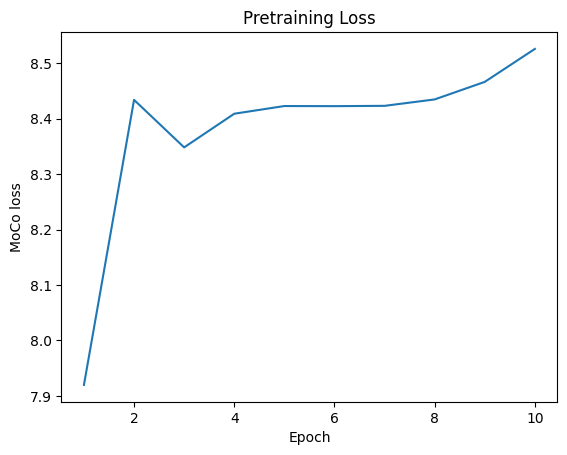

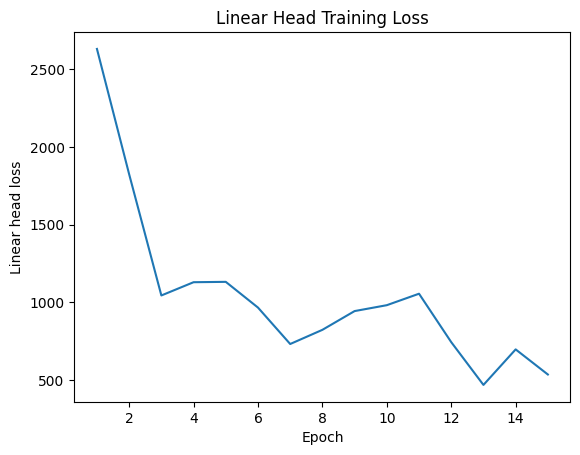

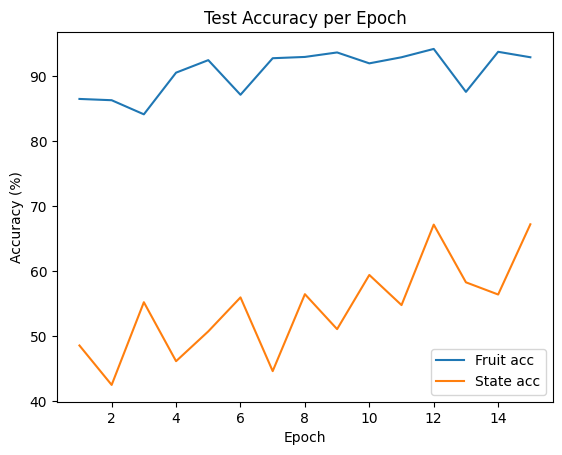

Final metrics (percentages where applicable):
{'fruit_acc': 92.9, 'state_acc': 67.19, 'fruit_bacc': 92.93, 'state_bacc': 67.49}
Rendering confusion matrices


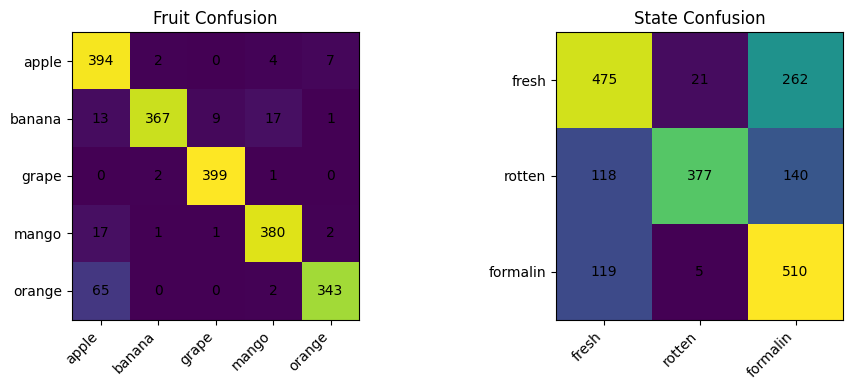

Pipeline complete


In [2]:
from __future__ import annotations
import os, random, math
from pathlib import Path
from typing import List, Tuple, Optional, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
import torchvision.models as models
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, balanced_accuracy_score

SEED = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_PRETRAIN = 128
BATCH_LINEAR = 256
EPOCHS_PRETRAIN = 10
EPOCHS_LINEAR = 15
LR_PRETRAIN = 0.3
LR_LINEAR = 30.0
WEIGHT_DECAY = 1e-4
CROP_SIZE = 224
NUM_WORKERS = 4
QUEUE_K = 8192
MOMENTUM_M = 0.999
TEMP_T = 0.2
PROJ_DIM = 128
MLP_HIDDEN = 2048
BACKBONE = 'resnet18'
TEST_RATIO = 0.2
OUTPUT_DIR = '/kaggle/working'

FRUITS = ["apple", "banana", "grape", "mango", "orange"]
STATES = ["fresh", "rotten", "formalin"]
STATE_NORMALIZE = {"formalin-mixed": "formalin", "formalin_mixed": "formalin", "formalin": "formalin", "fresh": "fresh", "rotten": "rotten"}
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    try:
        torch.set_float32_matmul_precision('high')
    except Exception:
        pass

AMP_ENABLED = torch.cuda.is_available()


def log(msg: str):
    print(msg, flush=True)


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def autodetect_data_root() -> Optional[str]:
    base = Path('/kaggle/input')
    if not base.exists():
        return None
    cands = []
    for p in base.rglob('*'):
        if p.is_dir():
            names = {d.name.lower() for d in p.iterdir() if d.is_dir()}
            if len(set(FRUITS) & names) >= 3:
                cands.append(p)
    if not cands:
        return None
    best = min(cands, key=lambda x: len(str(x)))
    return str(best)


class FruitStateDataset(Dataset):
    def __init__(self, root: str, transform=None):
        self.root = Path(root)
        self.transform = transform
        self.samples: List[Tuple[str, int, int]] = []
        for fruit_dir in sorted([d for d in self.root.iterdir() if d.is_dir()]):
            f = fruit_dir.name.lower()
            if f not in FRUITS:
                continue
            for state_dir in sorted([d for d in fruit_dir.iterdir() if d.is_dir()]):
                s_raw = state_dir.name.lower()
                s = STATE_NORMALIZE.get(s_raw, s_raw)
                if s not in STATES:
                    continue
                for img in state_dir.rglob('*'):
                    if img.suffix.lower() in IMG_EXTS:
                        self.samples.append((str(img), FRUITS.index(f), STATES.index(s)))
        if not self.samples:
            raise RuntimeError(f"No images found under {root}")
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        p, f, s = self.samples[idx]
        x = Image.open(p).convert('RGB')
        if self.transform:
            x = self.transform(x)
        return x, (f, s)


def stratified_split_indices(samples: List[Tuple[str, int, int]], test_ratio: float, seed: int = 42) -> Tuple[List[int], List[int]]:
    rng = random.Random(seed)
    groups: Dict[Tuple[int,int], List[int]] = {}
    for i, (_, f, s) in enumerate(samples):
        groups.setdefault((f,s), []).append(i)
    train_idx, test_idx = [], []
    for _, idxs in groups.items():
        rng.shuffle(idxs)
        n_test = max(1, int(len(idxs) * test_ratio)) if len(idxs) > 1 else 1
        test_idx.extend(idxs[:n_test])
        train_idx.extend(idxs[n_test:])
    rng.shuffle(train_idx)
    rng.shuffle(test_idx)
    return train_idx, test_idx


class TwoCropsTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return q, k


def moco_v2_augmentation(crop_size: int = CROP_SIZE):
    cj = T.ColorJitter(0.4, 0.4, 0.4, 0.1)
    base = T.Compose([
        T.RandomResizedCrop(crop_size, scale=(0.2, 1.0)),
        T.RandomHorizontalFlip(),
        T.RandomApply([cj], p=0.8),
        T.RandomGrayscale(p=0.2),
        T.GaussianBlur(kernel_size=int(0.1 * crop_size) // 2 * 2 + 1),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    return TwoCropsTransform(base)


def eval_transform(crop_size: int = CROP_SIZE):
    return T.Compose([
        T.Resize(int(crop_size * 256 / 224)),
        T.CenterCrop(crop_size),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])


class ProjectionMLP(nn.Module):
    def __init__(self, dim: int, hidden: int = MLP_HIDDEN, out: int = PROJ_DIM):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(dim, hidden), nn.ReLU(inplace=True), nn.Linear(hidden, out))
    def forward(self, x):
        return self.net(x)


def make_backbone(name: str):
    name = name.lower()
    if name == 'resnet18':
        m = models.resnet18(weights=None)
    elif name == 'resnet34':
        m = models.resnet34(weights=None)
    else:
        m = models.resnet50(weights=None)
    return m


class MoCo(nn.Module):
    def __init__(self, base_encoder_fn, dim=PROJ_DIM, K=QUEUE_K, m=MOMENTUM_M, T=TEMP_T, mlp_hidden=MLP_HIDDEN):
        super().__init__()
        self.encoder_q = base_encoder_fn()
        self.encoder_k = base_encoder_fn()
        feat_dim = self.encoder_q.fc.in_features
        self.encoder_q.fc = nn.Identity()
        self.encoder_k.fc = nn.Identity()
        self.proj_q = ProjectionMLP(feat_dim, hidden=mlp_hidden, out=dim)
        self.proj_k = ProjectionMLP(feat_dim, hidden=mlp_hidden, out=dim)
        for pq, pk in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            pk.data.copy_(pq.data)
            pk.requires_grad = False
        for pq, pk in zip(self.proj_q.parameters(), self.proj_k.parameters()):
            pk.data.copy_(pq.data)
            pk.requires_grad = False
        self.m = m
        self.T = T
        self.K = K
        self.register_buffer('queue', F.normalize(torch.randn(dim, K), dim=0))
        self.register_buffer('queue_ptr', torch.zeros(1, dtype=torch.long))
    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for pq, pk in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            pk.data = pk.data * self.m + pq.data * (1. - self.m)
        for pq, pk in zip(self.proj_q.parameters(), self.proj_k.parameters()):
            pk.data = pk.data * self.m + pq.data * (1. - self.m)
    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        bs = keys.shape[0]
        ptr = int(self.queue_ptr)
        end = ptr + bs
        if end <= self.K:
            self.queue[:, ptr:end] = keys.T
        else:
            first = self.K - ptr
            self.queue[:, ptr:] = keys[:first].T
            self.queue[:, :bs-first] = keys[first:].T
        self.queue_ptr[0] = (ptr + bs) % self.K
    def forward(self, im_q, im_k):
        q = F.normalize(self.proj_q(self.encoder_q(im_q)), dim=1)
        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = F.normalize(self.proj_k(self.encoder_k(im_k)), dim=1)
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach().to(q.dtype)])
        logits = torch.cat([l_pos, l_neg], dim=1) / self.T
        labels = torch.zeros(logits.size(0), dtype=torch.long, device=logits.device)
        self._dequeue_and_enqueue(k)
        return logits, labels


class _PretrainWrap(Dataset):
    def __init__(self, base: FruitStateDataset, transform):
        self.base = base
        self.transform = transform
    def __len__(self):
        return len(self.base)
    def __getitem__(self, i):
        x, _ = self.base[i]
        q, k = self.transform(x)
        return (q, k), 0


def build_pretrain_loader(ds: FruitStateDataset, idxs: List[int]) -> DataLoader:
    subset = Subset(ds, idxs)
    twocrop = moco_v2_augmentation(CROP_SIZE)
    wrap = _PretrainWrap(subset, twocrop)
    loader = DataLoader(
        wrap,
        batch_size=BATCH_PRETRAIN,
        shuffle=True,
        num_workers=NUM_WORKERS,
        drop_last=True,
        pin_memory=True,
        persistent_workers=NUM_WORKERS > 0,
    )
    log(f"Built pretrain loader with {len(loader)} batches")
    return loader


def build_linear_loader(ds: FruitStateDataset, idxs: List[int]) -> DataLoader:
    subset = Subset(FruitStateDataset(ds.root, transform=eval_transform(CROP_SIZE)), idxs)
    def collate(batch):
        xs, yf, ys = [], [], []
        for x, (f, s) in batch:
            xs.append(x); yf.append(f); ys.append(s)
        return torch.stack(xs,0), (torch.tensor(yf), torch.tensor(ys))
    loader = DataLoader(
        subset,
        batch_size=BATCH_LINEAR,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        persistent_workers=NUM_WORKERS > 0,
        collate_fn=collate,
    )
    log(f"Built linear-train loader with {len(loader)} batches")
    return loader


def build_test_loader(ds: FruitStateDataset, idxs: List[int]) -> DataLoader:
    subset = Subset(FruitStateDataset(ds.root, transform=eval_transform(CROP_SIZE)), idxs)
    def collate(batch):
        xs, yf, ys = [], [], []
        for x, (f, s) in batch:
            xs.append(x); yf.append(f); ys.append(s)
        return torch.stack(xs,0), (torch.tensor(yf), torch.tensor(ys))
    loader = DataLoader(
        subset,
        batch_size=BATCH_LINEAR,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        persistent_workers=NUM_WORKERS > 0,
        collate_fn=collate,
    )
    log(f"Built test loader with {len(loader)} batches")
    return loader


def pretrain_moco(train_loader: DataLoader, base_encoder_fn, epochs: int = EPOCHS_PRETRAIN):
    device = torch.device(DEVICE)
    model = MoCo(base_encoder_fn).to(device)
    opt = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=LR_PRETRAIN, momentum=0.9, weight_decay=WEIGHT_DECAY)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    scaler = torch.cuda.amp.GradScaler(enabled=AMP_ENABLED)
    losses = []
    log(f"Starting MoCo pretraining for {epochs} epochs on {DEVICE} (amp={AMP_ENABLED})")
    for ep in range(1, epochs+1):
        model.train()
        run = 0.0
        n = 0
        for (im_q, im_k), _ in train_loader:
            im_q = im_q.to(device, non_blocking=True)
            im_k = im_k.to(device, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
                logits, labels = model(im_q, im_k)
                loss = F.cross_entropy(logits, labels)
            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            run += float(loss.item()); n += 1
        sch.step()
        avg = run / max(1,n)
        losses.append(avg)
        ck = os.path.join(OUTPUT_DIR, f'moco_epoch_{ep}.pth')
        torch.save({'epoch': ep, 'state_dict': model.state_dict()}, ck)
        log(f"[MoCo] Epoch {ep}/{epochs} avg_loss={avg:.4f} saved={ck}")
    log("Finished MoCo pretraining")
    return model, losses


class DualHead(nn.Module):
    def __init__(self, in_dim: int):
        super().__init__()
        self.fruit = nn.Linear(in_dim, len(FRUITS))
        self.state = nn.Linear(in_dim, len(STATES))
    def forward(self, x):
        return self.fruit(x), self.state(x)


def load_frozen_encoder_from_moco(ckpt_path: str, backbone_name: str):
    enc = make_backbone(backbone_name)
    feat_dim = enc.fc.in_features
    enc.fc = nn.Identity()
    ck = torch.load(ckpt_path, map_location='cpu')
    enc_state = {k.replace('encoder_q.', ''): v for k, v in ck['state_dict'].items() if k.startswith('encoder_q.')}
    enc.load_state_dict(enc_state, strict=False)
    for p in enc.parameters():
        p.requires_grad = False
    log(f"Loaded frozen encoder from {ckpt_path}")
    return enc, feat_dim


def train_dual_linear_head(enc: nn.Module, feat_dim: int, train_loader: DataLoader, test_loader: DataLoader, epochs: int = EPOCHS_LINEAR):
    device = torch.device(DEVICE)
    enc = enc.to(device).eval()
    head = DualHead(feat_dim).to(device)
    opt = torch.optim.SGD(head.parameters(), lr=LR_LINEAR, momentum=0.9)
    ce = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=AMP_ENABLED)
    train_losses = []
    test_acc_fruits = []
    test_acc_states = []
    log(f"Starting linear head training for {epochs} epochs (amp={AMP_ENABLED})")
    for ep in range(1, epochs+1):
        head.train()
        run = 0.0; cnt = 0
        for x, (yf, ys) in train_loader:
            x = x.to(device, non_blocking=True); yf = yf.to(device, non_blocking=True); ys = ys.to(device, non_blocking=True)
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
                    feats = enc(x)
            with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
                lf, ls = head(feats)
                loss = ce(lf, yf) + ce(ls, ys)
            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            run += float(loss.item()); cnt += 1
        avg = run / max(1,cnt)
        train_losses.append(avg)
        head.eval()
        ytf, yts, ypf, yps = [], [], [], []
        with torch.no_grad():
            for x, (yf, ys) in test_loader:
                x = x.to(device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
                    feats = enc(x)
                    lf, ls = head(feats)
                ytf.extend(yf.numpy().tolist())
                yts.extend(ys.numpy().tolist())
                ypf.extend(lf.argmax(1).cpu().numpy().tolist())
                yps.extend(ls.argmax(1).cpu().numpy().tolist())
        acc_f = accuracy_score(ytf, ypf)
        acc_s = accuracy_score(yts, yps)
        test_acc_fruits.append(acc_f)
        test_acc_states.append(acc_s)
        log(f"[Linear] Epoch {ep}/{epochs} train_loss={avg:.4f} test_acc_fruit={acc_f*100:.2f}% test_acc_state={acc_s*100:.2f}%")
    log("Finished linear head training")
    return head, train_losses, test_acc_fruits, test_acc_states


def final_evaluation(enc: nn.Module, head: DualHead, test_loader: DataLoader):
    device = torch.device(DEVICE)
    enc = enc.to(device).eval(); head = head.to(device).eval()
    ytf, yts, ypf, yps = [], [], [], []
    with torch.no_grad():
        for x, (yf, ys) in test_loader:
            x = x.to(device, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=AMP_ENABLED):
                feats = enc(x)
                lf, ls = head(feats)
            ytf.extend(yf.numpy().tolist())
            yts.extend(ys.numpy().tolist())
            ypf.extend(lf.argmax(1).cpu().numpy().tolist())
            yps.extend(ls.argmax(1).cpu().numpy().tolist())
    prf_f = precision_recall_fscore_support(ytf, ypf, average='macro', zero_division=0)
    prf_s = precision_recall_fscore_support(yts, yps, average='macro', zero_division=0)
    bacc_f = balanced_accuracy_score(ytf, ypf)
    bacc_s = balanced_accuracy_score(yts, yps)
    cm_f = confusion_matrix(ytf, ypf, labels=list(range(len(FRUITS))))
    cm_s = confusion_matrix(yts, yps, labels=list(range(len(STATES))))
    log("Computed final evaluation metrics on test set")
    return {
        'fruit_acc': accuracy_score(ytf, ypf),
        'state_acc': accuracy_score(yts, yps),
        'fruit_prf_macro': prf_f,
        'state_prf_macro': prf_s,
        'fruit_bacc': bacc_f,
        'state_bacc': bacc_s,
        'cm_fruit': cm_f,
        'cm_state': cm_s,
        'ytf': ytf,
        'yts': yts,
        'ypf': ypf,
        'yps': yps,
    }

set_seed(SEED)
log("Starting FruitVision MoCo dual-head pipeline")
log(f"Device: {DEVICE}")
root = autodetect_data_root()
if root is None:
    root = "/kaggle/input/fvision/Fruits Original-ML-GRP-07"
log(f"Dataset root: {root}")
full_ds = FruitStateDataset(root, transform=None)
log(f"Total images: {len(full_ds)}")
fruit_counts = {f:0 for f in FRUITS}
state_counts = {s:0 for s in STATES}
for _, f, s in full_ds.samples:
    fruit_counts[FRUITS[f]] += 1
    state_counts[STATES[s]] += 1
log(f"Per-fruit counts: {fruit_counts}")
log(f"Per-state counts: {state_counts}")
train_idx, test_idx = stratified_split_indices(full_ds.samples, TEST_RATIO, seed=SEED)
log(f"Train size: {len(train_idx)} | Test size: {len(test_idx)}")
pretrain_loader = build_pretrain_loader(full_ds, train_idx)
train_loader = build_linear_loader(full_ds, train_idx)
test_loader = build_test_loader(full_ds, test_idx)
base_fn = (lambda: make_backbone(BACKBONE))
moco_model, pretrain_losses = pretrain_moco(pretrain_loader, base_fn, epochs=EPOCHS_PRETRAIN)
ckpt_path = os.path.join(OUTPUT_DIR, f"moco_epoch_{EPOCHS_PRETRAIN}.pth")
enc, feat_dim = load_frozen_encoder_from_moco(ckpt_path, BACKBONE)
head, lin_losses, test_acc_fruits, test_acc_states = train_dual_linear_head(enc, feat_dim, train_loader, test_loader, epochs=EPOCHS_LINEAR)
metrics = final_evaluation(enc, head, test_loader)
log("Plotting curves")
plt.figure()
plt.plot(range(1, len(pretrain_losses)+1), pretrain_losses)
plt.xlabel('Epoch'); plt.ylabel('MoCo loss'); plt.title('Pretraining Loss')
plt.show()
plt.figure()
plt.plot(range(1, len(lin_losses)+1), lin_losses)
plt.xlabel('Epoch'); plt.ylabel('Linear head loss'); plt.title('Linear Head Training Loss')
plt.show()
plt.figure()
plt.plot(range(1, len(test_acc_fruits)+1), [a*100 for a in test_acc_fruits], label='Fruit acc')
plt.plot(range(1, len(test_acc_states)+1), [a*100 for a in test_acc_states], label='State acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Test Accuracy per Epoch'); plt.legend()
plt.show()
log("Final metrics (percentages where applicable):")
print({
    'fruit_acc': round(metrics['fruit_acc']*100, 2),
    'state_acc': round(metrics['state_acc']*100, 2),
    'fruit_bacc': round(metrics['fruit_bacc']*100, 2),
    'state_bacc': round(metrics['state_bacc']*100, 2),
})
log("Rendering confusion matrices")
fig, ax = plt.subplots(1,2, figsize=(10,4))
im0 = ax[0].imshow(metrics['cm_fruit']); ax[0].set_title('Fruit Confusion')
ax[0].set_xticks(range(len(FRUITS))); ax[0].set_xticklabels(FRUITS, rotation=45, ha='right')
ax[0].set_yticks(range(len(FRUITS))); ax[0].set_yticklabels(FRUITS)
for i in range(metrics['cm_fruit'].shape[0]):
    for j in range(metrics['cm_fruit'].shape[1]):
        ax[0].text(j, i, metrics['cm_fruit'][i,j], ha='center', va='center')
im1 = ax[1].imshow(metrics['cm_state']); ax[1].set_title('State Confusion')
ax[1].set_xticks(range(len(STATES))); ax[1].set_xticklabels(STATES, rotation=45, ha='right')
ax[1].set_yticks(range(len(STATES))); ax[1].set_yticklabels(STATES)
for i in range(metrics['cm_state'].shape[0]):
    for j in range(metrics['cm_state'].shape[1]):
        ax[1].text(j, i, metrics['cm_state'][i,j], ha='center', va='center')
plt.tight_layout(); plt.show()
log("Pipeline complete")
